<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/SRM_A_Style_based_Recalibration_Module_for_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SRM : A Style-based Recalibration Module for Convolutional Neural Networks**

논문 링크: https://arxiv.org/abs/1903.10829

image의 정보는 크게 content과 style로 구분할 수 있는데, 최근의 연구를 통해 대부분의 image recognition 분야에서는 CNN이 인식하는데 있어서 style이 content보다 더 중요한 정보라고 소개가 되었다.

기존 style 관련 연구들은 style transfer 등 대부분이 image generation task 내에서 보통 진행이 되었다. 하지만 본 논문에서는 style의 중요도에 기반한 feature recalibration을 수행하여 model의 representational power를 향상 시킬 수 있는 **Style-based Recalibration Module(SRM)**을 제안한다.

## **Style-based Recalibration Module**

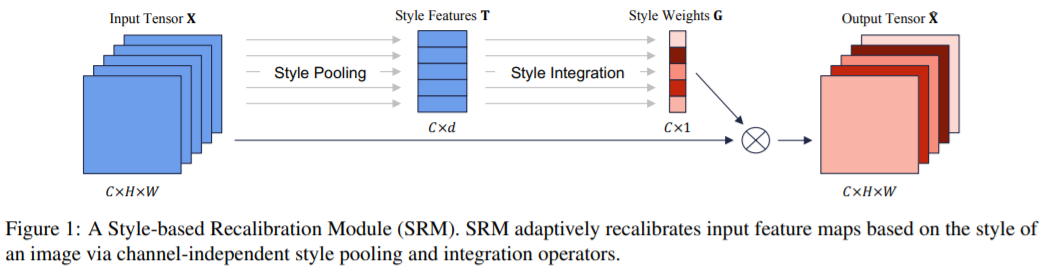

위의 그림 Figure 1을 보면 SRM의 구조를 알 수 있다. 위와 같이 크게 Style Pooling, Style Integration으로 나누어져 있다. style pooling operation은 input tensor의 style 정보가 담긴 style feature를 추출하는 역할이고, style integration operation은 이를 channel-wise operation을 통해 활용하여 example-specific한 style weight를 생성한다. style weight는 각 style의 상대적인 중요도이다.

### **Style Pooling**

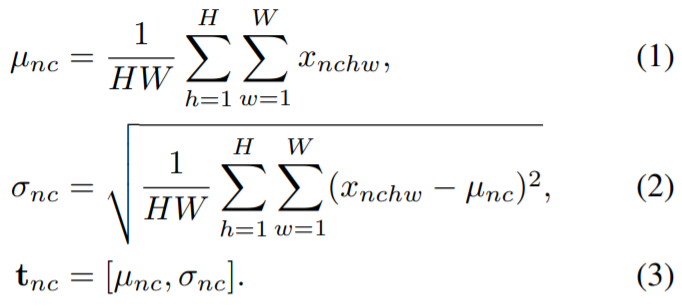

input feature map x_nchw가 주어지면 위의 식과 같이 평균과 표준 편차를 style feature로 추출한다. 이때 style vector t_nc는 각 channel에 대한 style information이 된다.

### **Style Integration**

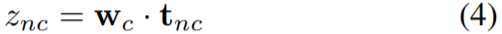

그리고 위에서 구한 style vector t_nc를 기반으로 각 channel별 상대적인 style의 중요도를 구한다.

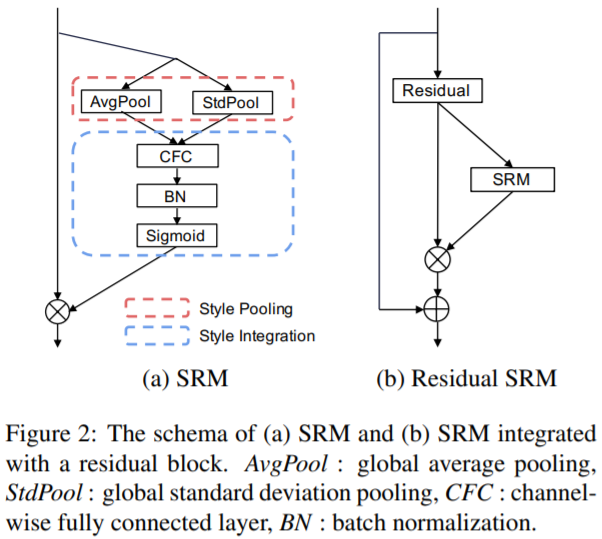

SRM은 위의 그림 Figure 2의 (b) 부분과 같이 residual block과 결합할 수 있으며, 기존 network와 함께 end-to-end로 학습이 가능하다.

In [1]:
import torch.nn as nn
import functools
import math
import torch
from torch.nn.parameter import Parameter

class SRMLayer(nn.Module):
    def __init__(self, channel):
        super(SRMLayer, self).__init__()

        self.cfc = Parameter(torch.Tensor(channel, 2))
        self.cfc.data.fill_(0)

        self.bn = nn.BatchNorm2d(channel)
        self.activation = nn.Sigmoid()

        setattr(self.cfc, 'srm_param', True)
        setattr(self.bn.weight, 'srm_param', True)
        setattr(self.bn.bias, 'srm_param', True)

    def _style_pooling(self, x, eps=1e-5):
        N, C, _, _ = x.size()

        channel_mean = x.view(N, C, -1).mean(dim=2, keepdim=True)
        channel_var = x.view(N, C, -1).var(dim=2, keepdim=True) + eps
        channel_std = channel_var.sqrt()

        t = torch.cat((channel_mean, channel_std), dim=2)
        return t 
    
    def _style_integration(self, t):
        z = t * self.cfc[None, :, :]  # B x C x 2
        z = torch.sum(z, dim=2)[:, :, None, None] # B x C x 1 x 1

        z_hat = self.bn(z)
        g = self.activation(z_hat)

        return g

    def forward(self, x):
        # B x C x 2
        t = self._style_pooling(x)

        # B x C x 1 x 1
        g = self._style_integration(t)

        return x * g

위의 코드는 본 논문 저자가 pytorch로 작성한 코드이다.

## **Experiments**

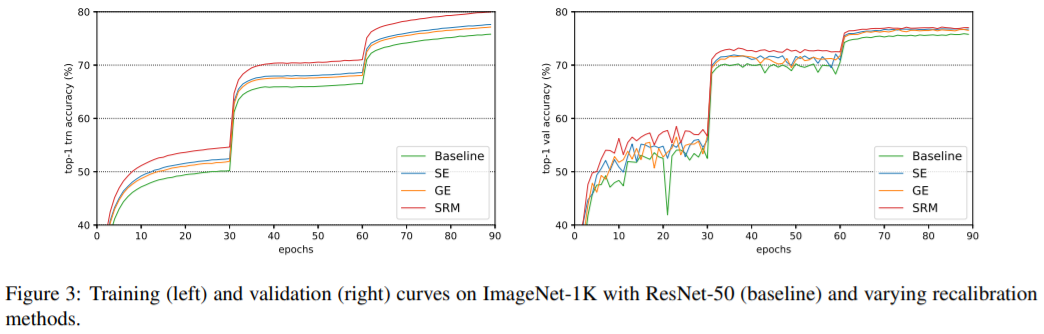

위의 그림 Figure 3은 SRM과 같이 feature recalibration을 통해 성능을 높이고자 한 모델인 SE, GE와 ImageNet에 대해 ResNet-50으로 비교를 한 것이다. SRM은 training curve와 validation curve에서 모두 우수한 성능을 보여준다.

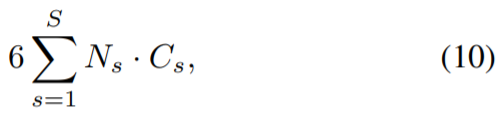

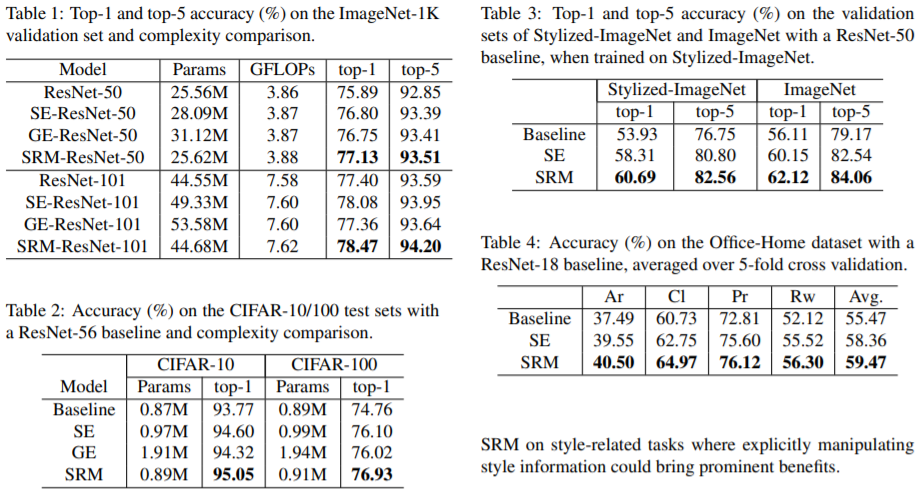

위의 표들 Table 1, 2을 보면 SRM은 ImageNet과 CIFAR-10/100에 대하여 **최소한의 parameter만 추가로 사용하며 높은 정확도**를 가지기 때문에 매우 효율적인 것을 알 수 있다.

위의 표 Table 3을 보면 Stylized ImageNet으로 훈련시켜 ImageNet에 얼마나 잘 일반화가 되는지 확인한 것이다. SRM의 일반화 성능이 가장 뛰어난 것을 알 수 있다.

위의 표 Table 4를 보면 각 도메인간에 명확한 스타일 차이가 존재하는 dataset인 Office-Home dataset에 대해 ResNet-18를 통해 성능을 비교하였다. 표에서 알 수 있듯이 가장 우수한 성능을 보여줬는데, **SRM이 서로 다른 domain간의 style 차이를 완화할 수 있음을 확인**할 수 있고, domain adaptation과 같은 task에 잘 활용될 수 있는 가능성을 보여준다.

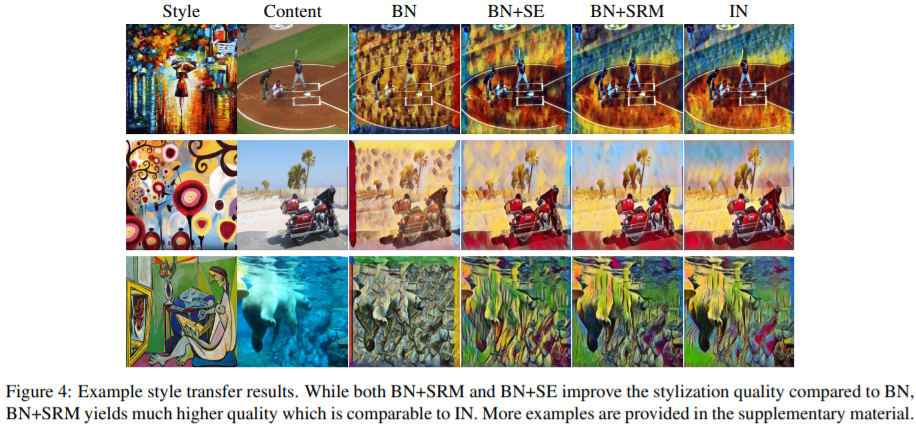

위의 그림 Figure 4를 통해 BN+SRM과 BN+SE가 모두 BN에 비해 stylization quality를 향상시키며, 뿐만아니라 BN+SRM이 IN보다 훨씬 더 우수하다.

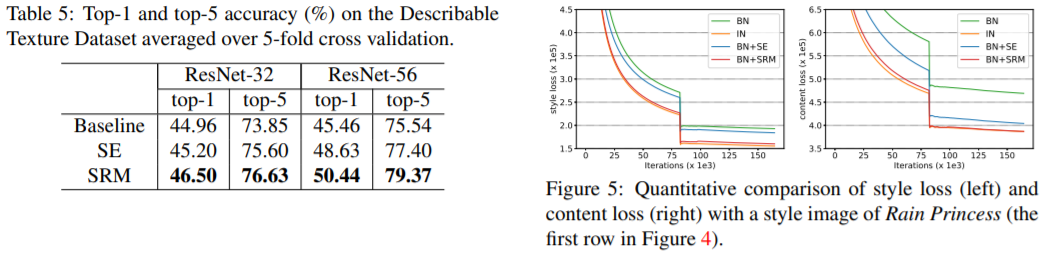

위의 표 Table 5는 Describable Texture dataset에 대한 결과물이고, 위의 그림 Figure 5는 Rain Princess에 대한 style loss이다. 위의 그림 Figure 4에서 언급했듯이 instacne normalization이 좋은 성능을 보여주는데, batch normalization + SRM 또한 동일한 수준의 성능을 보여준다. 하지만, BN + SRM이 IN에 비해 content imae의 중요한 style(녹색 유리나 푸른 하늘 등)을 더 잘 표현한다.

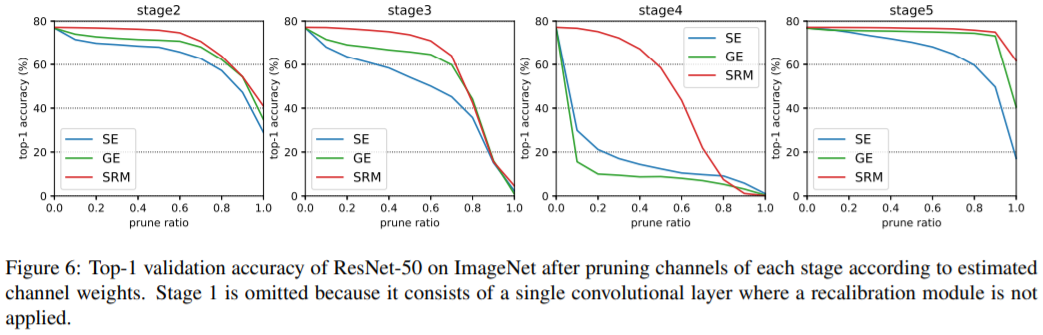

위의 그림 Figure 6은 channel pruning이 서로 다른 단계에서 SE, GE, SRM에 적용될 때 validation accuracy를 비교한 것이다. stage 1의 경우는 recalibration이 적용되지 않았음으로 제외하였다. 모든 단계에서 SRM이 SE나 GE에 비해 느리게 떨어지는데, 이는 곧 **SRM이 다른 방법보다 channel의 상대적인 중요성을 더욱 잘 학습**한다는 의미이다.

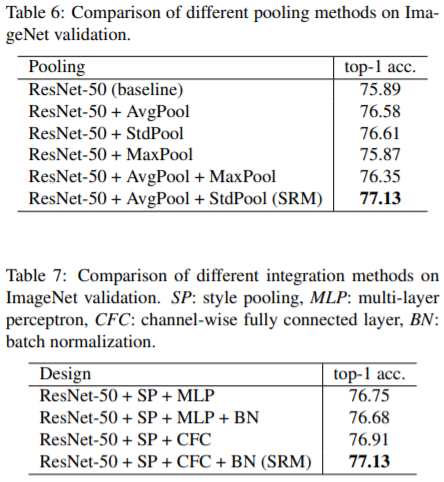

위의 표 Table 6은 다른 pooling들의 결과를 보여준다. 단일 측면에서 봤을때 AvgPool과 StdPool이 우수한 성능을 보여주며, 둘이 결합할시 더욱 성능을 향상시킨다.

위으 표 Table 7 또한 style integration에서 여러 기법들에 대한 성능을 보여준다. CFC와 BN이 제일 좋은 성능을 보여준다.

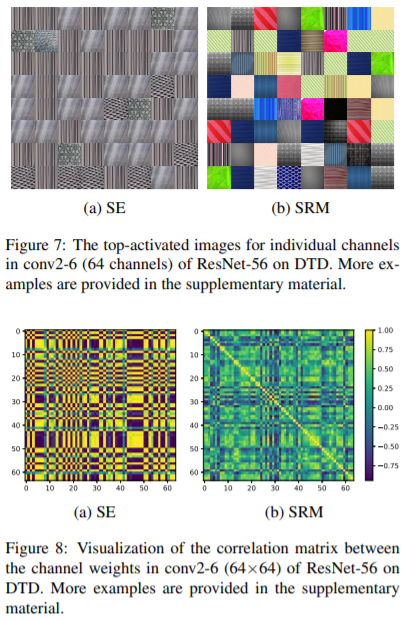

위의 그림들 Figure 7, 8에서는 SRM과 SE의 차이점을 보여준다.

SRM과 SE는 feature recalibration 측면에서 유사하지만, 위의 그림 Figure 7을 보면 SE는 channel 전체에서 image가 많이 겹치는 반면에 SRM은 더 다양한 상위 활성화 image를 생성한다.

또한, 위의 그림 Figure 8에서는 SE와 SRM의 생성된 channel weight간의 상관 행렬를 보여준다. SE는 channel간의 높은 상관 관계가 이는 반면 SRM은 상관 관계가 낮다. 이러한 점은 본 논문에서 추후 더 연구할 가치가 있다고 언급하였다.